In [ ]:
import seaborn as sns
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

In [ ]:
df=pd.read_csv('train_sample.csv')

In [ ]:
df.head()

,ip,app,device,os,channel,click_time,attributed_time,is_attributed
0,87540,12,1,13,497,2017-11-07 09:30:38,NaN,0
1,105560,25,1,17,259,2017-11-07 13:40:27,NaN,0
2,101424,12,1,19,212,2017-11-07 18:05:24,NaN,0
3,94584,13,1,13,477,2017-11-07 04:58:08,NaN,0
4,68413,12,1,1,178,2017-11-09 09:00:09,NaN,0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 8 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   ip               100000 non-null  int64 
 1   app              100000 non-null  int64 
 2   device           100000 non-null  int64 
 3   os               100000 non-null  int64 
 4   channel          100000 non-null  int64 
 5   click_time       100000 non-null  object
 6   attributed_time  227 non-null     object
 7   is_attributed    100000 non-null  int64 
dtypes: int64(6), object(2)
memory usage: 6.1+ MB


In [ ]:
df=df.drop('attributed_time',axis=1)

<Axes: xlabel='app', ylabel='count'>

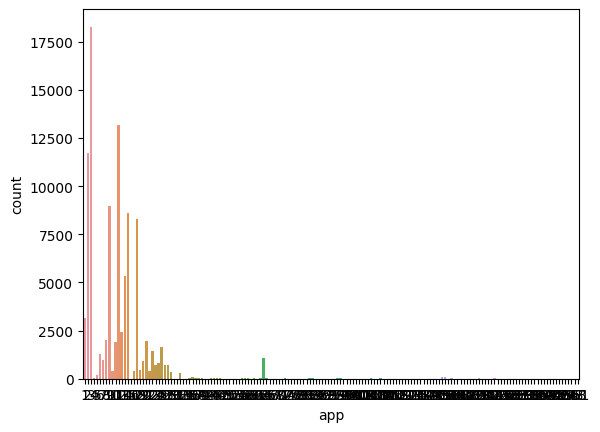

In [ ]:
sns.countplot(x=df['app'])

<Axes: xlabel='device', ylabel='count'>

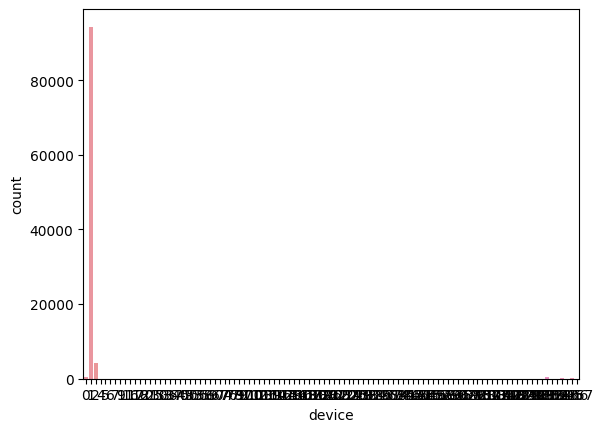

In [ ]:
sns.countplot(x=df['device'])

In [ ]:
df['ip'].value_counts().sort_values(ascending=False)

5348      669
5314      616
73487     439
73516     399
53454     280
         ... 
200443      1
30077       1
183597      1
106505      1
185961      1
Name: ip, Length: 34857, dtype: int64

<ipython-input-11-c0c4e01b3690>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df.corr(method='spearman'),annot=True)


<Axes: >

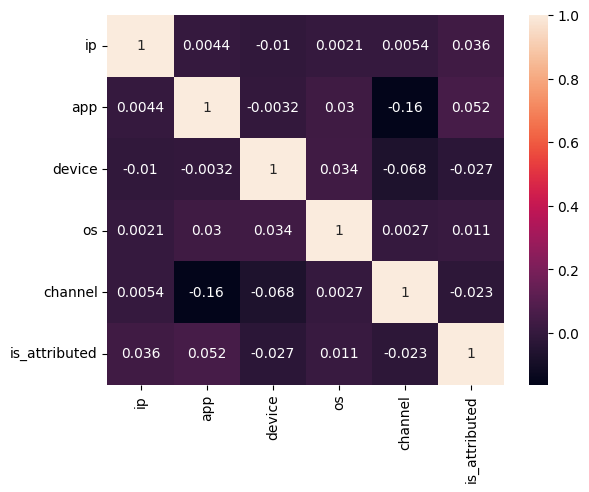

In [ ]:
sns.heatmap(df.corr(method='spearman'),annot=True)

In [ ]:
df=df[~df.duplicated()]

In [ ]:
df['ip'].nunique()

34857

In [ ]:
ip_1=df['ip'][df['is_attributed']==1]
ip_2=df['ip'][df['is_attributed']==0]
set_ip1=set(ip_1.unique())
set_ip2=set(ip_2.unique())
ip_download=set_ip1-set_ip2
ip_fraud=set_ip2-set_ip1
print(len(ip_fraud))
len(ip_download)

34634


150

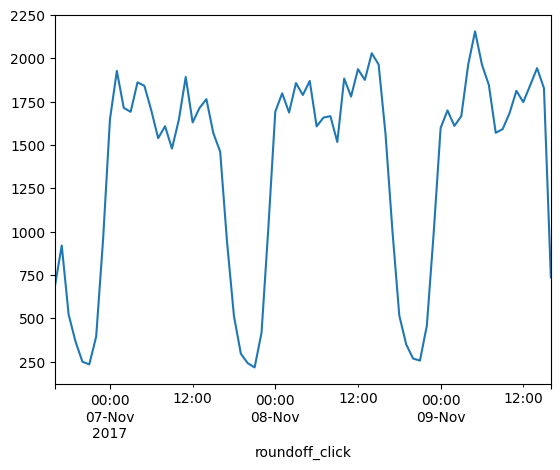

In [ ]:
df['click_time']=pd.to_datetime(df['click_time'])
df['roundoff_click']=df['click_time'].dt.round('H')
df_clicks=df.groupby('roundoff_click')['is_attributed'].count().plot()

In [ ]:
# no of clicks every day remains almost similar

In [ ]:
df.groupby('app')['is_attributed'].agg(['mean','count'])

,mean,count
app,,
1,0.000000,3135
2,0.000000,11737
3,0.000219,18279
4,0.000000,58
5,0.074468,188
...,...,...
486,0.000000,1
536,0.000000,1
538,0.000000,1


In [ ]:
df['day_of_week']=df['click_time'].dt.dayofweek
df['day_of_year']=df['click_time'].dt.dayofyear
df['month']=df['click_time'].dt.month
df['hour']=df['click_time'].dt.hour

In [ ]:
df=df.drop('roundoff_click',axis=1)

In [ ]:
df=df.drop('click_time',axis=1)

In [ ]:
X=df.drop('is_attributed',axis=1)
Y=df['is_attributed']

In [ ]:
from sklearn.model_selection import train_test_split
X_train,X_test,Y_train,Y_test=train_test_split(X,Y,test_size=0.2)

In [ ]:
from sklearn.tree import DecisionTreeClassifier
dtc=DecisionTreeClassifier()
dtc.fit(X_train,Y_train)

DecisionTreeClassifier()

In [ ]:
from sklearn import metrics
Y_pred=dtc.predict_proba(X_test)[:,1]
metrics.roc_auc_score(Y_test,Y_pred)

0.6434036186392312

In [ ]:
from sklearn.model_selection import GridSearchCV

In [ ]:
params={'max_depth':[5,10,15,20,30,40,100,200],
        'min_samples_split':[2,25,50,75],
        'min_samples_leaf':[2,25]}
dt=DecisionTreeClassifier()
model_cv=GridSearchCV(dt,param_grid=params,scoring='roc_auc',n_jobs=-1,cv=3,verbose=1,return_train_score=True)
model_cv.fit(X_train,Y_train)

Fitting 3 folds for each of 64 candidates, totalling 192 fits


GridSearchCV(cv=3, estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'max_depth': [5, 10, 15, 20, 30, 40, 100, 200],
                         'min_samples_leaf': [2, 25],
                         'min_samples_split': [2, 25, 50, 75]},
             return_train_score=True, scoring='roc_auc', verbose=1)

In [ ]:
model_cv.best_score_

0.8785203891430814

In [ ]:
model_cv.best_params_

{'max_depth': 30, 'min_samples_leaf': 25, 'min_samples_split': 75}

In [ ]:
dtc=DecisionTreeClassifier(max_depth=30,min_samples_leaf=25,min_samples_split=75)
dtc.fit(X_train,Y_train)
Y_pred=dtc.predict_proba(X_test)[:,1]
metrics.roc_auc_score(Y_test,Y_pred)

0.8778064622074642

##DecisionTree gives 85% test and 87.85% cv

In [ ]:
X_dev,X_test,Y_dev,Y_test=train_test_split(X,Y,test_size=0.2,random_state=56)
X_train,X_cv,Y_train,Y_cv=train_test_split(X_dev,Y_dev,test_size=0.25,random_state=56)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
train=[]
cv=[]
max_depth=[7,10,14,19,25,30]
samples_leaf=[]
n_estimators=[7,200,500]
for est in n_estimators:
  for dpt in max_depth:
    rfc=RandomForestClassifier(max_depth=dpt,n_estimators=est)
    rfc.fit(X_train,Y_train)
    Y_pred_train=rfc.predict_proba(X_train)[:,1]
    Y_pred_cv=rfc.predict_proba(X_cv)[:,1]
    train.append(metrics.roc_auc_score(Y_train,Y_pred_train))
    cv.append(metrics.roc_auc_score(Y_cv,Y_pred_cv))

<Axes: >

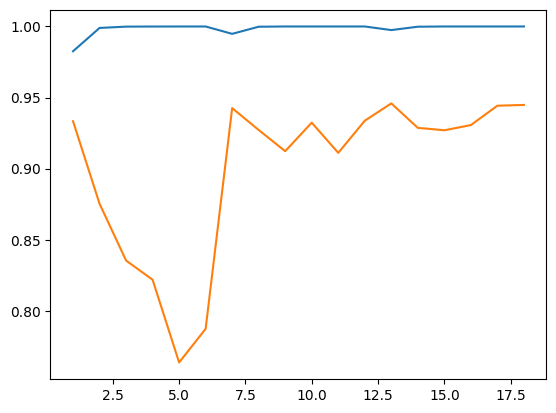

In [ ]:
sns.lineplot(x=np.arange(1,19),y=train)
sns.lineplot(x=np.arange(1,19),y=cv)

In [ ]:
#max param is 500,max_depth=7
rfc=RandomForestClassifier(max_depth=7,n_estimators=416)
rfc.fit(X_train,Y_train)
Y_pred_cv=rfc.predict_proba(X_cv)[:,1]
metrics.roc_auc_score(Y_cv,Y_pred_cv)

0.9513547149627513

In [ ]:
Y_pred=rfc.predict_proba(X_test)[:,1]
metrics.roc_auc_score(Y_test,Y_pred)

0.9510690548320467

## cv score for random forest is 95,while test auc is 95.1

In [ ]:
from sklearn.ensemble import AdaBoostClassifier

train=[]
cv=[]
max_depth=[2,5,10,15,20,30]
for lr in [0.01,0.1,0.6,1.2]:
  for dpt in max_depth:
    tree=DecisionTreeClassifier(max_depth=dpt)
    ABC=AdaBoostClassifier(base_estimator=tree,learning_rate=lr)
    ABC.fit(X_train,Y_train)
    Y_pred_train=ABC.predict_proba(X_train)[:,1]
    Y_pred_cv=ABC.predict_proba(X_cv)[:,1]
    train.append(metrics.roc_auc_score(Y_train,Y_pred_train))
    cv.append(metrics.roc_auc_score(Y_cv,Y_pred_cv))


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/en

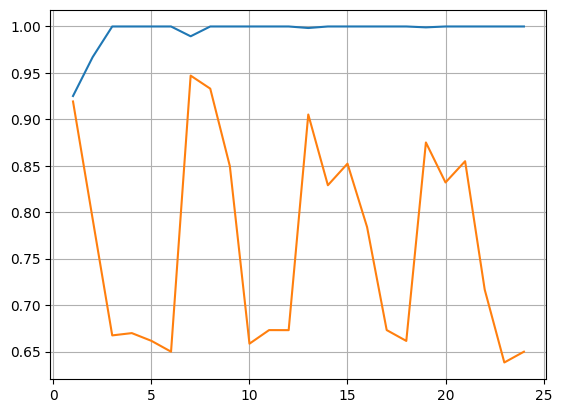

In [ ]:
sns.lineplot(x=np.arange(1,25),y=train)
sns.lineplot(x=np.arange(1,25),y=cv)
plt.grid()

In [ ]:
cv

[0.91926712198669,
 0.7929927250565458,
 0.6673907039670174,
 0.6698523919450073,
 0.6615129505180324,
 0.6498599896754768,
 0.94709905366305,
 0.9330694714566551,
 0.8495975649973023,
 0.6584493871125245,
 0.6730907497631535,
 0.6730406420315306,
 0.9052445315568006,
 0.8290563082720873,
 0.8522969733764804,
 0.7840001351743457,
 0.6731158036289651,
 0.6614377889205979,
 0.8751204624827099,
 0.8320528671527505,
 0.8549392822475299,
 0.7166489347445845,
 0.6382320826987326,
 0.6498349358096652]

In [ ]:
tree=DecisionTreeClassifier(max_depth=2)
ABC=AdaBoostClassifier(base_estimator=tree,learning_rate=0.79,n_estimators=15)
ABC.fit(X_train,Y_train)
Y_pred_cv=ABC.predict_proba(X_cv)[:,1]
metrics.roc_auc_score(Y_cv,Y_pred_cv)

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


0.9472930754610784

In [ ]:
Y_pred=ABC.predict_proba(X_test)[:,1]
metrics.roc_auc_score(Y_test,Y_pred)

0.962099231065344

##ADA Boost classifier cv accuracy=94.7,test =96.2
##parameter, max depth=2,estimator=15,lr=0.79

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
train=[]
cv=[]
max_depth=[2,5,10,17]
for lr in [0.1,0.6,1.3]:
  for dpt in max_depth:
    gbdt=GradientBoostingClassifier(max_depth=dpt,learning_rate=lr)
    gbdt.fit(X_train,Y_train)
    Y_pred_train=gbdt.predict_proba(X_train)[:,1]
    Y_pred_cv=gbdt.predict_proba(X_cv)[:,1]
    train.append(metrics.roc_auc_score(Y_train,Y_pred_train))
    cv.append(metrics.roc_auc_score(Y_cv,Y_pred_cv))

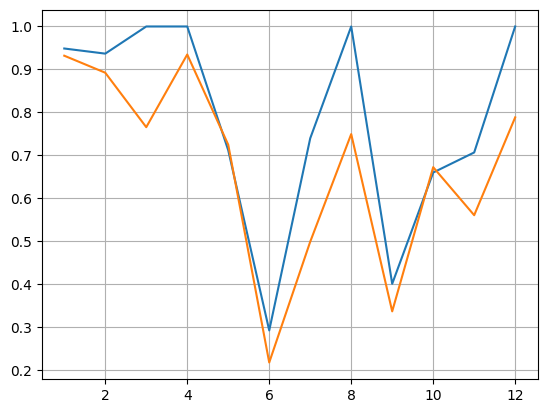

In [ ]:
sns.lineplot(x=np.arange(1,13),y=train)
sns.lineplot(x=np.arange(1,13),y=cv)
plt.grid()

In [ ]:
cv

[0.9319659360648649,
 0.8923668445296923,
 0.7655902049872342,
 0.934764977259247,
 0.7247424986977816,
 0.21787424357717933,
 0.4990025065518773,
 0.7494764907341482,
 0.3368573829081362,
 0.6724900396317198,
 0.5606664794424291,
 0.7883647516579251]

In [ ]:
gbdt=GradientBoostingClassifier(max_depth=2,learning_rate=0.1,n_estimators=90)
gbdt.fit(X_train,Y_train)

GradientBoostingClassifier(max_depth=2, n_estimators=90)

In [ ]:
Y_pred_cv=gbdt.predict_proba(X_cv)[:,1]
metrics.roc_auc_score(Y_cv,Y_pred_cv)


0.9319263159980002

In [ ]:
Y_pred=gbdt.predict_proba(X_test)[:,1]
metrics.roc_auc_score(Y_test,Y_pred)

0.8757596308772424

##GBDT cv=93.2,test=87.57

In [ ]:
from xgboost import XGBClassifier
train=[]
cv=[]
max_depth=[1,2,4,5,7,15]
for dpt in max_depth:
    xgbdt=XGBClassifier(max_depth=dpt)
    xgbdt.fit(X_train,Y_train)
    Y_pred_train=xgbdt.predict_proba(X_train)[:,1]
    Y_pred_cv=xgbdt.predict_proba(X_cv)[:,1]
    train.append(metrics.roc_auc_score(Y_train,Y_pred_train))
    cv.append(metrics.roc_auc_score(Y_cv,Y_pred_cv))


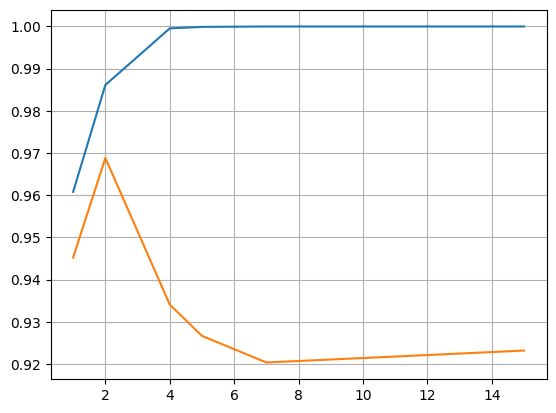

In [ ]:
sns.lineplot(x=max_depth,y=train)
sns.lineplot(x=max_depth,y=cv)
plt.grid()

In [ ]:
cv

[0.9452281707997777,
 0.9688184247294475,
 0.934076869921494,
 0.9266469420882805,
 0.9203473514567948,
 0.9231685332767776]

In [ ]:
from xgboost import XGBClassifier
train=[]
cv=[]
sub_sample=[0.3,0.5,0.7,0.92]
for sam in sub_sample:
    xgbdt=XGBClassifier(subsample=sam)
    xgbdt.fit(X_train,Y_train)
    Y_pred_train=xgbdt.predict_proba(X_train)[:,1]
    Y_pred_cv=xgbdt.predict_proba(X_cv)[:,1]
    train.append(metrics.roc_auc_score(Y_train,Y_pred_train))
    cv.append(metrics.roc_auc_score(Y_cv,Y_pred_cv))


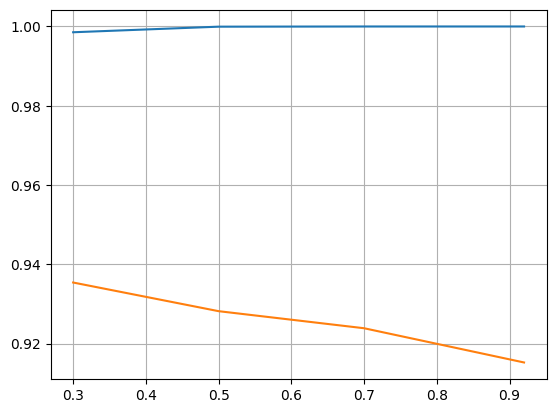

In [ ]:
sns.lineplot(x=sub_sample,y=train)
sns.lineplot(x=sub_sample,y=cv)
plt.grid()

In [ ]:
xgbdt=XGBClassifier(max_depth=2,subsample=0.9)
xgbdt.fit(X_train,Y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=2, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [ ]:
Y_pred_cv=xgbdt.predict_proba(X_cv)[:,1]
metrics.roc_auc_score(Y_cv,Y_pred_cv)

0.9641630668728464

In [ ]:
Y_pred=xgbdt.predict_proba(X_test)[:,1]
metrics.roc_auc_score(Y_test,Y_pred)

0.9396000814680456

In [ ]:
train=[]
cv=[]
learning_rate=[0.06,0.1,0.5,0.9,2]
for lr in learning_rate:
    xgbdt=XGBClassifier(learning_rate=lr)
    xgbdt.fit(X_train,Y_train)
    Y_pred_train=xgbdt.predict_proba(X_train)[:,1]
    Y_pred_cv=xgbdt.predict_proba(X_cv)[:,1]
    train.append(metrics.roc_auc_score(Y_train,Y_pred_train))
    cv.append(metrics.roc_auc_score(Y_cv,Y_pred_cv))

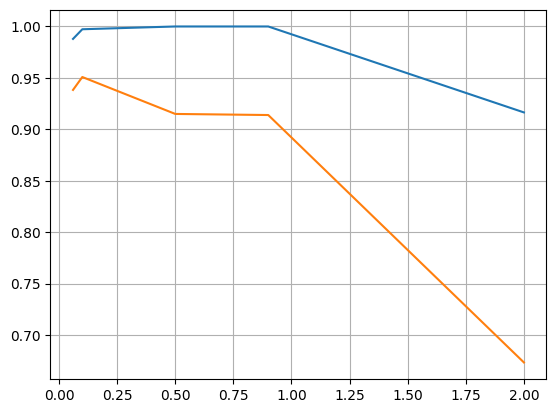

In [ ]:
sns.lineplot(x=learning_rate,y=train)
sns.lineplot(x=learning_rate,y=cv)
plt.grid()

In [ ]:
xgbdt=XGBClassifier(max_depth=2,subsample=0.9,learning_rate=0.11)
xgbdt.fit(X_train,Y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.11, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=2, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [ ]:
Y_pred_cv=xgbdt.predict_proba(X_cv)[:,1]
metrics.roc_auc_score(Y_cv,Y_pred_cv)

0.9618674335868629

In [ ]:
Y_pred=xgbdt.predict_proba(X_test)[:,1]
metrics.roc_auc_score(Y_test,Y_pred)

0.9349012733114308

In [ ]:
train=[]
cv=[]
max_depth=[2,5,10]
for lr in [0.07,0.09,0.1,0.6,1.3]:
  for dpt in max_depth:
    xgbdt=XGBClassifier(max_depth=dpt,learning_rate=lr)
    xgbdt.fit(X_train,Y_train)
    Y_pred_train=xgbdt.predict_proba(X_train)[:,1]
    Y_pred_cv=xgbdt.predict_proba(X_cv)[:,1]
    train.append(metrics.roc_auc_score(Y_train,Y_pred_train))
    cv.append(metrics.roc_auc_score(Y_cv,Y_pred_cv))

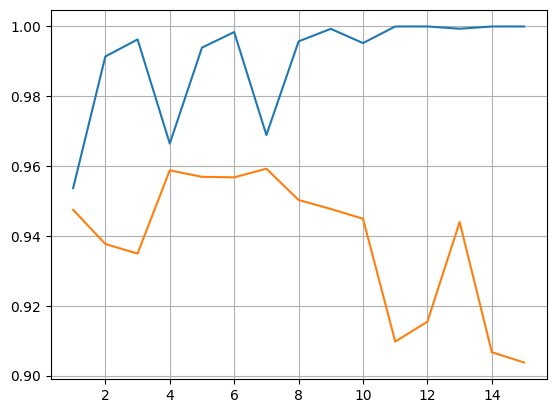

In [ ]:
sns.lineplot(x=np.arange(1,16),y=train)
sns.lineplot(x=np.arange(1,16),y=cv)
plt.grid()

In [ ]:
from imblearn.over_sampling import SMOTE


In [ ]:
xgbdt=XGBClassifier(max_depth=3,learning_rate=0.11,n_estimators=200)
xgbdt.fit(X_train,Y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.11, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=200, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [ ]:
Y_pred_cv=xgbdt.predict_proba(X_cv)[:,1]
metrics.roc_auc_score(Y_cv,Y_pred_cv)

0.9617905240453021

In [ ]:

Y_pred=xgbdt.predict_proba(X_test)[:,1]
metrics.roc_auc_score(Y_test,Y_pred)

0.956211991797746

##XGBDT gives accuracy cv=96.2,test=95.6

In [ ]:
sm = SMOTE(random_state=42)
X_res, Y_res = sm.fit_resample(X, Y)

In [ ]:
X_dev,X_test,Y_dev,Y_test=train_test_split(X_res,Y_res,test_size=0.2,random_state=56)
X_train,X_cv,Y_train,Y_cv=train_test_split(X_dev,Y_dev,test_size=0.25,random_state=56)

In [ ]:
X_train.shape

(119726, 9)

In [ ]:
train=[]
cv=[]
max_depth=[1,2,4,5,7,15]
for dpt in max_depth:
    xgbdt=XGBClassifier(max_depth=dpt)
    xgbdt.fit(X_train,Y_train)
    Y_pred_train=xgbdt.predict_proba(X_train)[:,1]
    Y_pred_cv=xgbdt.predict_proba(X_cv)[:,1]
    train.append(metrics.roc_auc_score(Y_train,Y_pred_train))
    cv.append(metrics.roc_auc_score(Y_cv,Y_pred_cv))


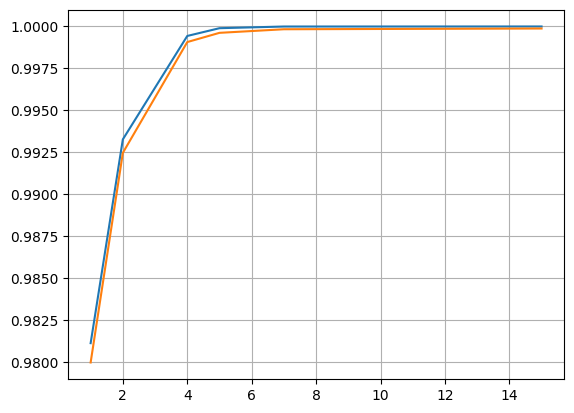

In [ ]:
sns.lineplot(x=max_depth,y=train)
sns.lineplot(x=max_depth,y=cv)
plt.grid()

In [ ]:
cv

[0.9799952860657409,
 0.9924764566986086,
 0.9990720167099802,
 0.9996214776086868,
 0.9998349620725441,
 0.9998785665922952]

In [ ]:
xgbdt=XGBClassifier(max_depth=5,learning_rate=0.1,n_estimators=200)
xgbdt.fit(X_train,Y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=200, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [ ]:
Y_pred_cv=xgbdt.predict_proba(X_cv)[:,1]
metrics.roc_auc_score(Y_cv,Y_pred_cv)

0.9991821386845989

In [ ]:

Y_pred=xgbdt.predict_proba(X_test)[:,1]
metrics.roc_auc_score(Y_test,Y_pred)

0.9992293104981841

## With upsampling we reached auc for cv=99.91
## test =99.92 whereas the highest was around 98.5